<a href="https://colab.research.google.com/github/analuisabarcelos/mvp-ml-sprint3/blob/main/MVP_ML_%26_Analytics_AnaLuisaBarcelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MVP: *Machine Learning & Analytics para prever se uma pessoa é saudável ou não*
**Autor:** Ana Luisa dos Santos Barcelos  

**Data:** 27/08/2025

**Matrícula:** 4052024001930

**Dataset:** [Fitness Classification Dataset (Synthetic)](https://www.kaggle.com/datasets/muhammedderric/fitness-classification-dataset-synthetic/data)



## ✅ Checklist do MVP (o que precisa conter)
- [ ] **Problema definido** e contexto de negócio
- [ ] **Carga e preparação** dos dados (sem vazamento de dados)
- [ ] **Divisão** em treino/validação/teste (ou validação cruzada apropriada)
- [ ] **Tratamento**: limpeza, transformação e **engenharia de atributos**
- [ ] **Modelagem**: comparar abordagens/modelos (com **baseline**)
- [ ] **Otimização de hiperparâmetros**
- [ ] **Avaliação** com **métricas adequadas** e discussão de limitações
- [ ] **Boas práticas**: seeds fixas, tempo de treino, recursos computacionais, documentação
- [ ] **Pipelines reprodutíveis** (sempre que possível)



## 1. Escopo, objetivo e definição do problema

- Escopo: Este projeto consiste em desenvolver um modelo preditivo que classifique se uma pessoa é 'fit' (saudável) ou 'não fit', baseando-se em um conjunto de dados sintético com métricas de saúde e estilo de vida.

- Objetivo: O objetivo é que o classificador possa ser usado como base para um aplicativo de bem-estar ou para análise de perfis de saúde.

- Tipo de Tarefa: Trata-se de um problema de classificação binária, onde o alvo é a variável is_fit.


-> Hipóteses a serem confirmadas:

 Hipótese 1 (Nutrição): Pessoas com uma pontuação (nutrition_quality) mais alta têm maior probabilidade de serem classificadas como 'fit' (is_fit = 1)

 Hipótese 2 (Hábito de fumar): Indivíduos que fumam (smokes) têm menor probabilidade de serem 'fit' em comparação com os que não fumam

 Hipótese 3 (Sono): Uma maior média de horas de sono (sleep_hours) está positivamente associada a ser 'fit'

 Hipótese 4 (Índice de Massa Corporal - IMC): Pessoas com um IMC dentro da faixa saudável (entre 18.5 e 24.9) têm maior chance de serem 'fit'


## 2. Reprodutibilidade e ambiente

In [29]:
# Setup básico
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel # para a feature selection
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.svm import SVC
from scipy.stats import uniform, loguniform
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_auc_score

# Visualização
warnings.filterwarnings("ignore") # Limpando a visualização
pd.set_option('display.max_columns', None) # Mostrando todas as colunas
sns.set_style('whitegrid') # Definindo o estilo dos gráficos

# Definindo a semente para garantir reprodutibilidade
SEED = 42
np.random.seed(SEED)


## 3. Dados: carga, entendimento e qualidade

In [30]:
# Carga dos dados

# URL do dataset no Kaggle
url = 'https://raw.githubusercontent.com/analuisabarcelos/mvp-ml-sprint3/refs/heads/main/fitness_dataset.csv'

# Guardando o dataset em um dataframe
df = pd.read_csv(url)

In [31]:
# Verificações básicas iniciais
display(df.head(5))
print("\nFormato:", df.shape)
print("\nTipos:")
print(df.dtypes)
print("\nValores ausentes por coluna:")
print(df.isna().sum())
print("\nResumo estatístico dos dados:")
display(df.describe())

,age,height_cm,weight_kg,heart_rate,blood_pressure,sleep_hours,nutrition_quality,activity_index,smokes,gender,is_fit
0,56,152,65,69.6,117.0,NaN,2.37,3.97,no,F,1
1,69,186,95,60.8,114.8,7.5,8.77,3.19,0,F,1
2,46,192,103,61.4,116.4,NaN,8.20,2.03,0,F,0
3,32,189,83,60.2,130.1,7.0,6.18,3.68,0,M,1
4,60,175,99,58.1,115.8,8.0,9.95,4.83,yes,F,1



Formato: (2000, 11)

Tipos:
age                    int64
height_cm              int64
weight_kg              int64
heart_rate           float64
blood_pressure       float64
sleep_hours          float64
nutrition_quality    float64
activity_index       float64
smokes                object
gender                object
is_fit                 int64
dtype: object

Valores ausentes por coluna:
age                    0
height_cm              0
weight_kg              0
heart_rate             0
blood_pressure         0
sleep_hours          160
nutrition_quality      0
activity_index         0
smokes                 0
gender                 0
is_fit                 0
dtype: int64

Resumo estatístico dos dados:


,age,height_cm,weight_kg,heart_rate,blood_pressure,sleep_hours,nutrition_quality,activity_index,is_fit
count,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000,1840.000000,2000.000000,2000.000000,2000.000000
mean,49.114000,174.53300,83.540500,70.288600,119.908850,7.513315,5.035140,2.999040,0.399500
std,17.926564,14.37175,25.852534,11.846339,14.578032,1.502031,2.864156,1.136383,0.489918
min,18.000000,150.00000,30.000000,45.000000,90.000000,4.000000,0.000000,1.000000,0.000000
25%,34.000000,162.00000,64.000000,62.100000,109.700000,6.500000,2.547500,2.037500,0.000000
50%,49.000000,174.00000,83.000000,70.250000,120.000000,7.500000,5.065000,2.980000,0.000000
75%,65.000000,187.00000,102.000000,78.425000,129.800000,8.600000,7.470000,3.950000,1.000000
max,79.000000,199.00000,250.000000,118.600000,171.200000,12.000000,10.000000,4.990000,1.000000


Foi visto que há tanto features numéricas quanto categóricas.

A variável-alvo _is_fit_ é uma variável númerica, não necessitando de one hot encoding para ela.

A feature _sleep_hours_ apresentou 160 dados faltantes, que serão tratados mais a frente, na etapa de pré-processamento.

A feature _smoke_ precisará de transformação, pois contém uma mistura de valores numéricos e textuais, exigindo padronização. Serão confirmados agora os dados distintos para transformá-los.

In [32]:
print("\nValores distintos da coluna 'smokes':")
print(df['smokes'].unique())


Valores distintos da coluna 'smokes':
['no' '0' 'yes' '1']


In [33]:
# Copiando o dataframe para salvarmos o original por enquanto
df_proc = df.copy()

# Limpeza e padronização de 'smokes'
# Transformando em valores numéricos
smoke_map = {'yes': 1, 'no': 0, '1': 1, '0': 0, '1.0': 1, '0.0': 0}
df_proc['smokes'] = df_proc['smokes'].map(smoke_map)

# Tratamento de possíveis NaNs e formatação para inteiro (sem casas decimais)
df_proc['smokes'] = df_proc['smokes'].fillna(0).astype(int)

# Usando Engenharia de features para criar e formatar a coluna 'imc', convertendo altura de cm para metros e calculando o IMC
df_proc['height_m'] = df_proc['height_cm'] / 100
df_proc['imc'] = (df_proc['weight_kg'] / (df_proc['height_m'] ** 2)).round(1) # Formatação arredondando para 1 casa decimal

# Visualizando as 5 primeiras linhas com as transformações feitas
print("\nAmostra do dataset após as transformações:")
display(df_proc.head())


Amostra do dataset após as transformações:


,age,height_cm,weight_kg,heart_rate,blood_pressure,sleep_hours,nutrition_quality,activity_index,smokes,gender,is_fit,height_m,imc
0,56,152,65,69.6,117.0,NaN,2.37,3.97,0,F,1,1.52,28.1
1,69,186,95,60.8,114.8,7.5,8.77,3.19,0,F,1,1.86,27.5
2,46,192,103,61.4,116.4,NaN,8.20,2.03,0,F,0,1.92,27.9
3,32,189,83,60.2,130.1,7.0,6.18,3.68,0,M,1,1.89,23.2
4,60,175,99,58.1,115.8,8.0,9.95,4.83,1,F,1,1.75,32.3



### 3.1 Análise exploratória resumida (EDA)

Para guiar a análise, foram levantadas quatro hipóteses principais no início deste projeto. Os gráficos a seguir, incluindo a criação da feature imc para testar a hipótese 4, validam todas as hipóteses

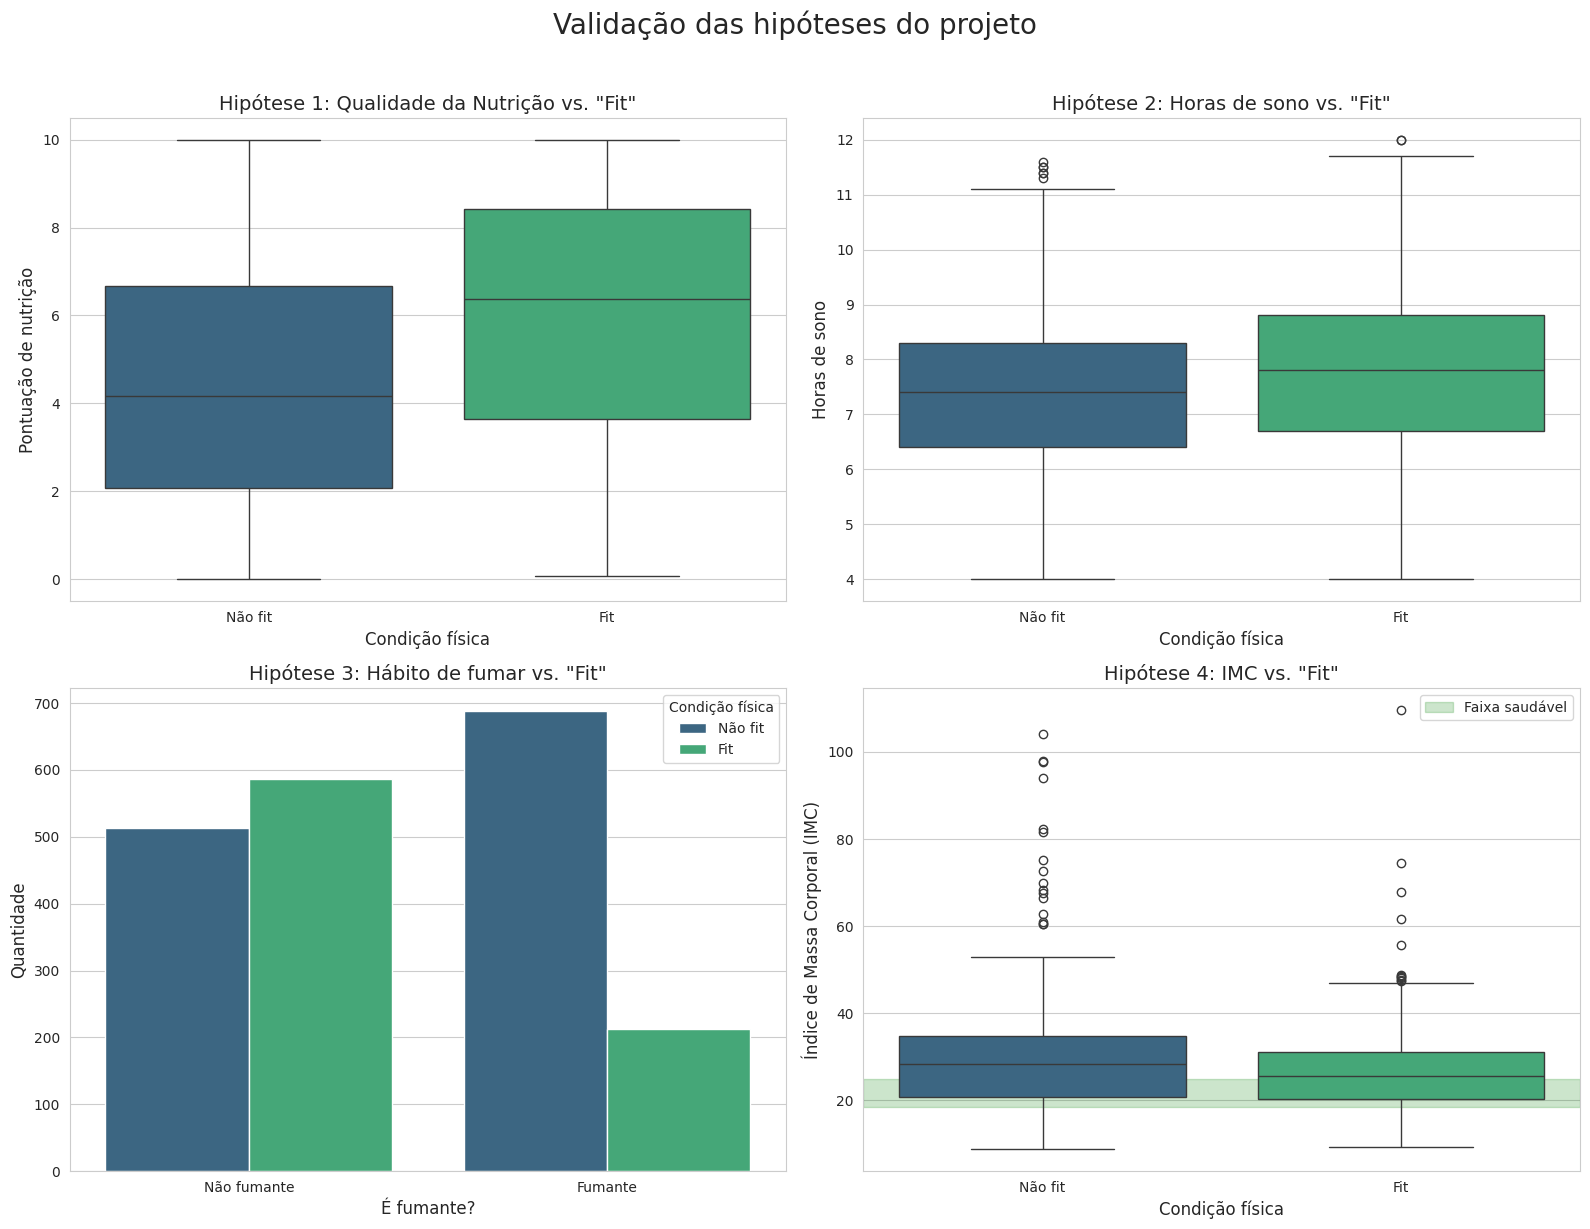

In [34]:
# EDA: Validação visual das hipóteses levantadas

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Validação das hipóteses do projeto', fontsize=20, y=1.02)

# Gráfico 1: Teste da Hipótese 1 (Nutrição)
sns.boxplot(ax=axes[0, 0], x='is_fit', y='nutrition_quality', data=df_proc, palette='viridis')
axes[0, 0].set_title('Hipótese 1: Qualidade da Nutrição vs. "Fit"', fontsize=14)
axes[0, 0].set_xticklabels(['Não fit', 'Fit'])
axes[0, 0].set_xlabel("Condição física", fontsize=12)
axes[0, 0].set_ylabel("Pontuação de nutrição", fontsize=12)

# Gráfico 2: Teste da Hipótese 2 (Sono)
sns.boxplot(ax=axes[0, 1], x='is_fit', y='sleep_hours', data=df_proc, palette='viridis')
axes[0, 1].set_title('Hipótese 2: Horas de sono vs. "Fit"', fontsize=14)
axes[0, 1].set_xticklabels(['Não fit', 'Fit'])
axes[0, 1].set_xlabel("Condição física", fontsize=12)
axes[0, 1].set_ylabel("Horas de sono", fontsize=12)

# Gráfico 3: Teste da Hipótese 3 (Hábito de fumar)
sns.countplot(ax=axes[1, 0], x='smokes', hue='is_fit', data=df_proc, palette='viridis')
axes[1, 0].set_title('Hipótese 3: Hábito de fumar vs. "Fit"', fontsize=14)
axes[1, 0].set_xticklabels(['Não fumante', 'Fumante'])
axes[1, 0].set_xlabel("É fumante?", fontsize=12)
axes[1, 0].set_ylabel("Quantidade", fontsize=12)
axes[1, 0].legend(title='Condição física', labels=['Não fit', 'Fit'])

# Gráfico 4: Teste da Hipótese 4 (IMC)
sns.boxplot(ax=axes[1, 1], x='is_fit', y='imc', data=df_proc, palette='viridis')
axes[1, 1].set_title('Hipótese 4: IMC vs. "Fit"', fontsize=14)
axes[1, 1].set_xticklabels(['Não fit', 'Fit'])
axes[1, 1].set_xlabel("Condição física", fontsize=12)
axes[1, 1].set_ylabel("Índice de Massa Corporal (IMC)", fontsize=12)
axes[1, 1].axhspan(18.5, 24.9, color='green', alpha=0.2, label='Faixa saudável') # Considerando de 18.5 a 24.9 como uma faixa saudável
axes[1, 1].legend()

plt.tight_layout()
plt.show()

Todas as 4 hipóteses foram confirmadas através dos gráficos acima, nos quais puderam ser observadas features muito fortes (_nutrition_quality_, _smokes_ e _imc_) e outra relevante (_sleep_hours_)

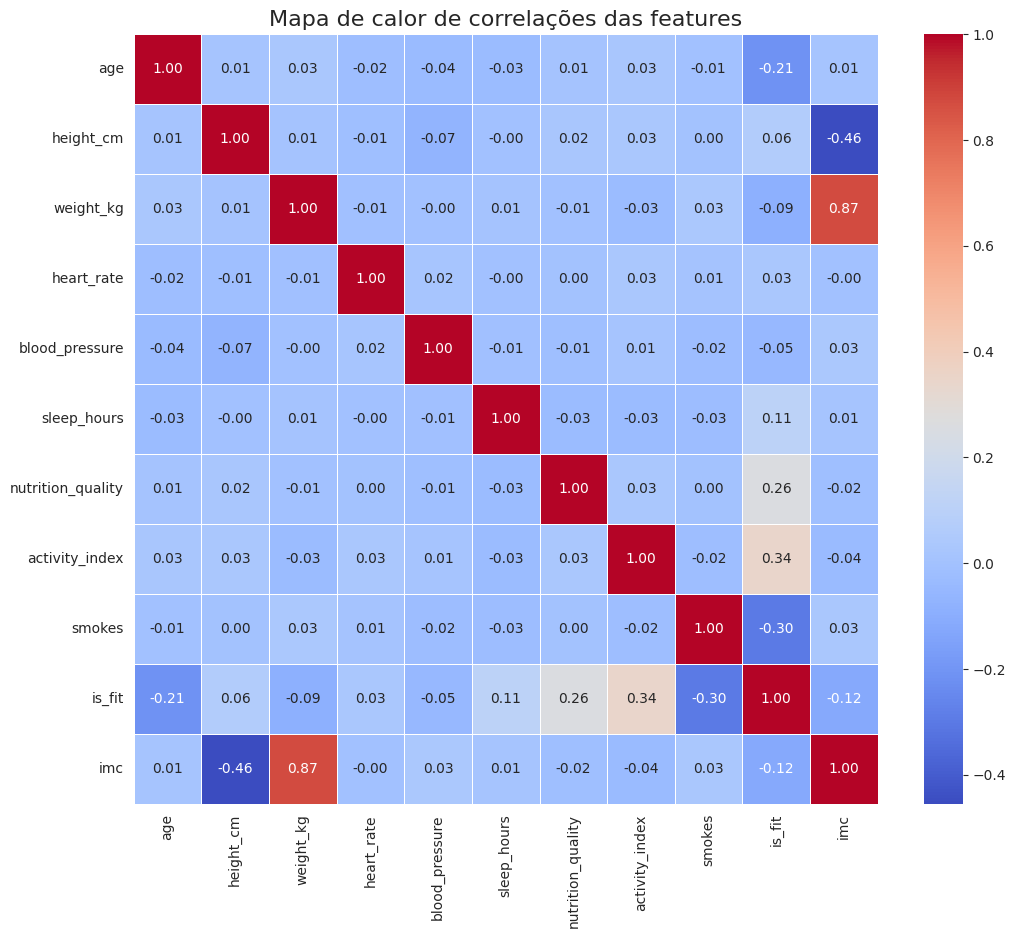

In [35]:
# Visualizando o Heatmap (Mapa de calor) para identificar se as correlações são relevantes ou não
# Selecionando apenas as colunas numéricas e excluindo colunas de texto ou auxiliares como height_m
colunas_numericas = df_proc.select_dtypes(include=np.number).columns.drop('height_m', errors='ignore')

# Calculando a matriz de correlação
correlation_matrix = df_proc[colunas_numericas].corr()

# Criando o mapa de calor
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Mapa de calor de correlações das features', fontsize=16)
plt.show()

Com o mapa de calor, pôde ser confirmado que as features _nutrition_quality_ e _activity_index_ têm correlação lineares importantes com a variável-alvo, sendo algumas das maiores correlações e positivas, ou seja, quanto maior a qualidade da nutrição e o nível de atividade, mais chance da pessoa ser saudável.

Também pode-se avaliar que a feature _smokes_ vista anteriormente como visualmente forte, através dos gráficos de barras, possui a segunda correlação linear mais forte com a variável-alvo, indicando sua importância.

Curiosamente, a feature criada _imc_ tem maior correlação do que as features _height_cm_ e _weight_kg_, usadas para sua criação. Isso ocorre porque o IMC não é apenas uma simples combinação, mas uma métrica que fornece um contexto sobre a composição corporal de uma pessoa que nem altura, nem peso conseguem fornecer de maneira isolada. Além disso, identifica-se uma alta correlação entre _weight_kg_ e a feature criada _imc_, pelo simples fato de _imc_ ter sido criada a partir do peso também.


## 4. Definição do target, variáveis e divisão dos dados

In [36]:
# Separar em treino/teste

# Definindo o alvo (y) e as features (X)
target = 'is_fit'
features = df.columns.drop(target) # Todas as colunas, exceto o alvo

X = df[features]
y = df[target]

# Dividindo em conjuntos de Treino e Teste e usando stratify=y para garantir a proporção
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,       # 20% dos dados para teste
    random_state=SEED,   # Garante a mesma divisão sempre que rodarmos
    stratify=y           # Mantém a proporção das classes
)

print(f"Formato do X_train: {X_train.shape}")
print(f"Formato do X_test: {X_test.shape}")

Formato do X_train: (1600, 10)
Formato do X_test: (400, 10)



## 5. Tratamento de dados e **Pipeline** de pré-processamento

Para evitar data leakage (vazamento de dados), as etapas de pré-processamento foram feitas no Pipeline. Este pipeline automatiza:
- A limpeza da coluna smokes
- A criação da feature imc
- A imputação de dados faltantes com a mediana para colunas numéricas
- A transformação de variáveis categóricas (gender) em formato numérico usando One-Hot Encoding
- A padronização da escala de todas as features numéricas usando StandardScaler

In [37]:
# Construindo o pipeline de pré-processamento

# Transformador para limpar a coluna 'smokes'
class SmokesCleaner(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_copy = X.copy()
        smoke_map = {'yes': 1, 'no': 0, '1': 1, '0': 0, '1.0': 1, '0.0': 0}
        X_copy['smokes'] = X_copy['smokes'].astype(str).str.lower().str.strip().map(smoke_map)
        X_copy['smokes'] = X_copy['smokes'].fillna(0).astype(int)
        return X_copy[['smokes']]

    def get_feature_names_out(self, input_features=None): # Usando get names para apresentar as importâncias depois
        return ['smokes']

# Transformador para criar a coluna 'imc'
class IMCCreator(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_copy = X.copy()
        X_copy['height_m'] = X_copy['height_cm'] / 100
        X_copy['imc'] = (X_copy['weight_kg'] / (X_copy['height_m']**2)).round(1)
        return X_copy[['imc']]

    def get_feature_names_out(self, input_features=None):
        return ['imc']

# Montando o preprocessor
numeric_features = ['age', 'height_cm', 'weight_kg', 'heart_rate', 'blood_pressure', 'sleep_hours', 'nutrition_quality', 'activity_index']
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])

categorical_features = ['gender']
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore', drop='if_binary'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('smokes_cleaner', SmokesCleaner(), ['smokes']),
        ('imc_creator', IMCCreator(), ['height_cm', 'weight_kg'])
    ],
    remainder='drop'
)

# Construindo o pipeline e usando feature selection
pipeline_com_selecao = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selector', SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=SEED))),
    ('classifier', RandomForestClassifier(random_state=SEED))
])

pipeline_com_selecao

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'height_cm',
                                                   'weight_kg', 'heart_rate',
                                                   'blood_pressure',
                                                   'sleep_hours',
                                                   'nutrition_quality',
                                                   'activity_index']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore'))]),
                                                  ['gender']),
                                                 ('smokes_cleaner',
                                                  SmokesCleaner(), ['smokes']),
                                                 ('imc_creator', IMCCreator(),
                                                  ['height_cm',
                                                   'weight_kg'])])),
                ('feature_selector',
                 SelectFromModel(estimator=RandomForestClassifier(random_state=42))),
                ('classifier', RandomForestClassifier(random_state=42))])

In [38]:
# Visualizando os dados que passaram pelo pipeline
# Treinando o preprocessor usando os dados de treino
preprocessor.fit(X_train, y_train)

# Usando o preprocessor treinado para transformar os dados de treino
X_train_transformado = preprocessor.transform(X_train)

# Criando um novo DataFrame do pandas para visualização
nomes_features_transformadas = preprocessor.get_feature_names_out()
df_transformado = pd.DataFrame(X_train_transformado, columns=nomes_features_transformadas)

print("\nVisualizando os dados que passaram pelo pipeline:")
display(df_transformado.head())


Visualizando os dados que passaram pelo pipeline:


,num__age,num__height_cm,num__weight_kg,num__heart_rate,num__blood_pressure,num__sleep_hours,num__nutrition_quality,num__activity_index,cat__gender_M,smokes_cleaner__smokes,imc_creator__imc
0,-0.396509,0.015599,-0.708377,0.211607,2.181059,0.201353,0.908659,1.236269,1.0,0.0,21.2
1,-0.676604,-1.513857,1.025924,-0.969877,0.545461,0.896871,-0.195825,0.990719,1.0,0.0,47.4
2,0.219699,1.266972,-0.746079,-0.573236,-1.514433,1.661941,1.310289,1.578285,0.0,1.0,17.2
3,-0.228452,0.015599,0.384987,1.604071,0.182756,-0.007303,1.241043,-1.263082,1.0,1.0,30.7
4,0.947945,0.432723,0.007965,-0.066886,0.839732,-1.537443,0.240429,-1.684025,1.0,0.0,25.6


In [39]:
# Visualizando a importância das features

# Treinando o pipeline com os dados de treino
pipeline_com_selecao.fit(X_train, y_train)

# Acessando as informações do pipeline treinado
feature_selector = pipeline_com_selecao.named_steps['feature_selector']
preprocessor_treinado = pipeline_com_selecao.named_steps['preprocessor']

# Extraindo as importâncias do modelo dentro do SelectFromModel
importancias = feature_selector.estimator_.feature_importances_

# Obtendo os nomes das features após todas as transformações do preprocessor
nomes_features_transformadas = preprocessor_treinado.get_feature_names_out()

# Criando um dataframe para visualizar e ordenar as importâncias
df_importancias = pd.DataFrame({
    'feature': nomes_features_transformadas,
    'importance': importancias
}).sort_values('importance', ascending=False)

print("\n Importância de cada variável na predição (usando RandomForestClassifier):")
display(df_importancias)


 Importância de cada variável na predição (usando RandomForestClassifier):


,feature,importance
7,num__activity_index,0.196077
6,num__nutrition_quality,0.141563
0,num__age,0.109213
9,smokes_cleaner__smokes,0.088819
10,imc_creator__imc,0.085604
5,num__sleep_hours,0.077191
3,num__heart_rate,0.076534
4,num__blood_pressure,0.072845
2,num__weight_kg,0.071561
1,num__height_cm,0.062855


Foi descoberto, usando feature selection, que a feature _age_ tem mais importância do que as features _smokes_ e _imc_, presentes nas hipóteses.


## 6. Baseline e modelos candidatos


### 6.1 Treino e avaliação rápida (baseline vs candidatos)

A modelagem é iniciada comparando três algoritmos (Regressão Logística, SVM e Random Forest) contra o algoritmo baseline DummyClassifier. A avaliação será feita usando validação cruzada.

Baseline (Dummy): Acurácia média = 0.6006 (Desvio padrão = 0.0019)
Logistic Regression: Acurácia média = 0.7450 (Desvio padrão = 0.0547)
SVM: Acurácia média = 0.7481 (Desvio padrão = 0.0410)
Random Forest: Acurácia média = 0.7181 (Desvio padrão = 0.0496)


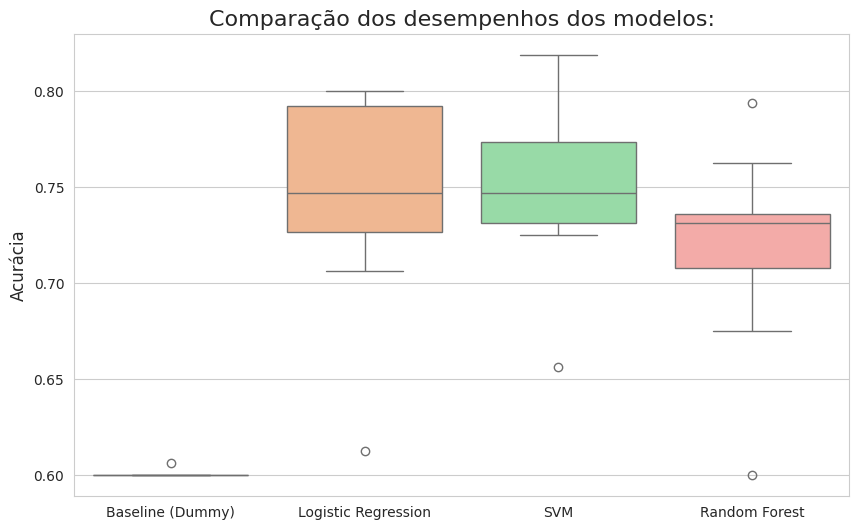

In [40]:
# Modelagem e avaliação dos modelos

# Modelo baseline (DummyClassifier) irá prever a classe mais frequente
baseline = DummyClassifier(strategy='most_frequent', random_state=SEED)

# Candidato 1: Regressão logística (RL)
pipeline_rl = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selector', SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=SEED))),
    ('classifier', LogisticRegression(random_state=SEED))
])

# Candidato 2: Máquina de Vetores de Suporte (SVM)
pipeline_svm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selector', SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=SEED))),
    ('classifier', SVC(random_state=SEED))
])

# Candidato 3: RandomForest que já tinhamos
pipeline_rf = pipeline_com_selecao

# Avaliando usando validação cruzada
# Lista de modelos para avaliação
modelos = {
    'Baseline (Dummy)': baseline,
    'Logistic Regression': pipeline_rl,
    'SVM': pipeline_svm,
    'Random Forest': pipeline_rf
}

# Usando Acurácia como métrica principal
scoring = 'accuracy'
results = []
names = []

# treinando e avaliando cada modelo
for name, model in modelos.items():
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)

    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)

    results.append(cv_results)
    names.append(name)

    print(f"{name}: Acurácia média = {cv_results.mean():.4f} (Desvio padrão = {cv_results.std():.4f})")


# Visualizando a comparação dos resultados entre os modelos
plt.figure(figsize=(10, 6))
sns.boxplot(data=results, palette='pastel')
plt.xticks(ticks=np.arange(len(names)), labels=names)
plt.title('Comparação dos desempenhos dos modelos:', fontsize=16)
plt.ylabel('Acurácia', fontsize=12)
plt.show()

Todos os algoritmos candidatos tiveram maior acurácia do que o algoritmo baseline, com 60% de acurácia.
<p>Os resultados indicaram que o SVM foi o modelo com a melhor combinação de acurácia média (74.8%) e desvio padrão. Por isso, foi escolhido para a etapa de otimização de hiperparâmetros a seguir


## 7. Validação e Otimização de Hiperparâmetros

In [41]:
# Otimizando os hiperparâmetros de SVM (C, kernel e gamma)

# Relembrando o pipeline sem classificador
pipeline_base = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selector', SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=SEED)))
])

# Adicionando o SVM ao final do pipeline base
pipeline_svm_para_tuning = Pipeline(steps=[
    ('base', pipeline_base),
    ('classifier', SVC(random_state=SEED, probability=True))
])

# Definindo o espaço de busca dos hiperparâmetros
param_dist = {
    'classifier__C': loguniform(0.1, 100), # Buscando valores de C entre 0.1 e 100
    'classifier__kernel': ['linear', 'rbf'], # Testando os dois tipos de kernel
    'classifier__gamma': loguniform(0.001, 1) # Buscando valores de gamma entre 0.001 e 1 para o kernel rbf
}

# Configurando a validação cruzada
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)

# Configurando a busca aleatória (Randomized Search), usando n_iter=10 para testar em 10 combinações diferentes
random_search = RandomizedSearchCV(
    estimator=pipeline_svm_para_tuning,
    param_distributions=param_dist,
    n_iter=10,
    cv=kfold,
    scoring='accuracy',
    random_state=SEED,
    n_jobs=-1,
    verbose=1
)

random_search.fit(X_train, y_train)

# Mostrando os melhores resultados encontrados
print(f"Melhor acurácia: {random_search.best_score_:.4f}")
print("\nMelhores hiperparâmetros encontrados:")
print(random_search.best_params_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Melhor acurácia: 0.7506

Melhores hiperparâmetros encontrados:
{'classifier__C': np.float64(6.847920095574778), 'classifier__gamma': np.float64(0.002621087878265439), 'classifier__kernel': 'rbf'}


A etapa de otimização de hiperparâmetros para o modelo SVM resultou em uma melhora na acurácia média para 75.1%


## 8. Avaliação final, análise de erros e limitações

Performance no conjunto de teste:

              precision    recall  f1-score   support

     Não Fit       0.72      0.83      0.77       240
         Fit       0.67      0.51      0.58       160

    accuracy                           0.70       400
   macro avg       0.69      0.67      0.67       400
weighted avg       0.70      0.70      0.69       400


ROC AUC: 0.7720


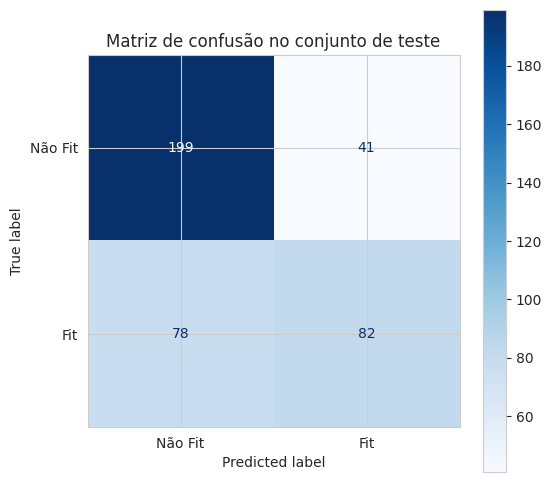

In [42]:
# Avaliação da aplicação do modelo no conjunto de teste

best_model = random_search.best_estimator_

# Fazendo as previsões no conjunto de teste
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test) # Probabilidades para o ROC AUC

# Avaliando a performance do modelo com as métricas
print("Performance no conjunto de teste:\n")
print(classification_report(y_test, y_pred, target_names=['Não Fit', 'Fit']))

# Calculando o ROC AUC
roc_auc = roc_auc_score(y_test, y_proba[:, 1])
print(f"\nROC AUC: {roc_auc:.4f}")

# Visualizando a matriz de confusão
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                                        display_labels=['Não Fit', 'Fit'],
                                        cmap='Blues',
                                        ax=ax)
plt.title('Matriz de confusão no conjunto de teste')
plt.show()

A acurácia do modelo nos dados de teste foi de 70%, menor do que os 75% alcançados no treino.
<p>Para a classe não fit, que é a maioria, o modelo conseguiu identificar corretamente 83% dos casos em que as pessoas são não fit, com precisão de 72%.

Já para a classe fit (minoria no dataset), de todos que eram realmente fit o modelo só conseguiu identificar corretamente 51%, sendo a outra metade classificada incorretamente como não fit.

<p>Ou seja, o modelo se saiu melhor em classificar quem é não fit (recall de 83%). Em termos práticos, o principal risco de usar esse modelo é que ele classifique uma pessoa fit como se ela não fosse.

O AUC de 0,77 (>0,5) apontou que as predições são boas, não são aleatórias.

## 9. Conclusão

O modelo SVM com os hiperparâmetros otimizados foi usado no conjunto de teste, alcançando uma acurácia geral de 70% e um AUC de 0.77. O desempenho se mostrou superior ao baseline e uma boa capacidade de prever a variável-alvo com dados não vistos.

Foi observado também que o modelo é melhor na identificação da classe majoritária ('Não Fit'), com um recall de 83%. Porém, pode apresentar dificuldade em identificar a classe minoritária ('Fit'), com um recall menor, de 51%. Pode-se concluir que o modelo é mais conservador, funcionando bem para  identificar perfis não-saudáveis, mas com espaço para melhorias em detectar os perfis saudáveis.

Como próximos passos, sugere-se a exploração de técnicas para melhorar o recall da classe 'Fit'. Também pode-se sugerir a coleta de mais dados, especialmente de perfis 'Fit', o que poderia ajudar a balancear melhor o aprendizado do modelo.